In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import dowhy
from dowhy import CausalModel

from econml.dml import DML
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from functools import reduce

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

d:\Documents\JACOBS\Master Thesis\MasterThesisCode\thesis_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import cdt
import networkx as nx
import matplotlib.pyplot as plt

# load data and preprocess

In [3]:
waste = pd.read_csv("country_waste.csv").drop(['gdp'], axis = 1)
circular_material_use_rate = pd.read_csv("circular_material_use_rate.csv", thousands=',')
material_flow = pd.read_csv("material_flow.csv", thousands=',')
gdp = pd.read_csv("gdp.csv")
raw_material_consumption = pd.read_csv("raw_material_consumption.csv", thousands=',')
recycling_rate = pd.read_csv("recycling_rate.csv", thousands=',')
joined_df = pd.DataFrame()
waste.rename({'country_name': 'country'}, axis=1, inplace=True)

dfs = [circular_material_use_rate, gdp, material_flow,raw_material_consumption,recycling_rate,waste]

joined_df  = reduce(lambda  left,right: pd.merge(left,right,on=['country'],how='outer'), dfs)
joined_df = joined_df.dropna(axis=1, how='all')
joined_df = joined_df.replace(':', np.NaN)

# for e in joined_df.columns:
#     print(e)

In [4]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

for col in joined_df.iloc[:,1:10]:
    
    # print(col)
    # print(joined_df[col].dtype)
    
    replacement = []

    for e in joined_df[col]:
        if e == np.NaN:
            pass
        else:
            e = str(e).replace(',', '')
        replacement.append(e)
        
    joined_df[col] = pd.Series(replacement).replace('nan', np.NaN)
    joined_df[col] = pd.to_numeric(joined_df[col])


In [5]:
print(len(joined_df.columns))
joined_df.isnull().sum()
joined_df.to_csv('file_name.csv', index=False)

59


In [6]:
joined_df.dropna(subset=["country","gdp","population_population_number_of_people"], inplace=True)
joined_df[["country","gdp","population_population_number_of_people"]].isna().sum()

new_df = joined_df.loc[:,["country",
                            "population_population_number_of_people",
                            "gdp",
                            "waste_collection_coverage_total_percent_of_waste",
                            "total_msw_total_msw_generated_tons_year",
                            "raw_material_consumption",
                            "recycling_rate",
                            "total_material_flow",
                            "circular_material_use_rate"]]
new_df = new_df.reset_index(drop=True)


In [7]:
new_df.isnull().sum()

country                                               0
population_population_number_of_people                0
gdp                                                   0
waste_collection_coverage_total_percent_of_waste    156
total_msw_total_msw_generated_tons_year               2
raw_material_consumption                            178
recycling_rate                                      185
total_material_flow                                 179
circular_material_use_rate                          178
dtype: int64

In [8]:
new_col_names = ["country","population","gdp","waste_collection_coverage_percent","waste_generated","raw_material_consumption","recycling_rate","total_material_flow","circular_material_use_rate"]
new_df.columns.values[:] = new_col_names
new_df

new_df.to_csv('file_name.csv', index=False)

In [9]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

test_df = joined_df.loc[:,["population_population_number_of_people",
                           "gdp",
                           "waste_collection_coverage_total_percent_of_waste",
                           "total_msw_total_msw_generated_tons_year",
                           "raw_material_consumption",
                           "recycling_rate",
                           "total_material_flow",
                           "circular_material_use_rate"]]



df_train = test_df

imputer = IterativeImputer(random_state=100, max_iter=100, min_value=[0,0,0,0,0,0,0,0],
                           max_value=[np.inf,np.inf,100,np.inf,np.inf,100,np.inf,100])
imputer.fit(df_train)

imputed_array = imputer.transform(df_train)

col_names = ["population",
                "gdp",
                "waste_collection_coverage_percent",
                "waste_generated",
                "raw_material_consumption",
                "recycling_rate",
                "total_material_flow",
                "circular_material_use_rate"]

df_imputed = pd.DataFrame(imputed_array, columns=col_names,)
df_imputed["country"] = new_df["country"]



cols = df_imputed.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_imputed = df_imputed[cols]
new_df = df_imputed


In [10]:
new_df

,country,population,gdp,waste_collection_coverage_percent,waste_generated,raw_material_consumption,recycling_rate,total_material_flow,circular_material_use_rate
0,Belgium,11484055.0,5.358660e+11,97.740000,4.765883e+06,165978.404000,87.000000,12979.000000,23.500000
1,Bulgaria,7025037.0,6.891193e+10,98.300000,2.859190e+06,151346.993000,49.203630,661.000000,2.300000
2,Denmark,5818553.0,3.464990e+11,100.000000,4.910858e+06,140876.941000,63.000000,3957.000000,7.600000
3,Estonia,1326590.0,3.108190e+10,86.890000,4.895117e+05,36857.495000,57.819690,295.000000,15.600000
4,Ireland,4867316.0,3.993220e+11,92.040000,2.910655e+06,71070.458000,68.015905,2814.000000,1.600000
...,...,...,...,...,...,...,...,...,...
198,Samoa,187665.0,9.129506e+08,84.680474,2.739909e+04,48894.262868,56.472189,1635.727075,9.600963
199,Kosovo,1801800.0,7.899741e+09,84.316871,3.190000e+05,76470.169940,56.824303,2047.533037,9.420281
200,South Africa,51729344.0,3.885310e+11,83.935134,1.845723e+07,820182.856561,16.569416,0.000000,0.000000
201,Zambia,14264756.0,2.330867e+10,81.411329,2.608268e+06,290875.927510,56.800381,4371.600697,7.544828


In [11]:
new_df.isnull().sum()

country                              0
population                           0
gdp                                  0
waste_collection_coverage_percent    0
waste_generated                      0
raw_material_consumption             0
recycling_rate                       0
total_material_flow                  0
circular_material_use_rate           0
dtype: int64

# exploratory analysis

In [12]:
new_df.head()

,country,population,gdp,waste_collection_coverage_percent,waste_generated,raw_material_consumption,recycling_rate,total_material_flow,circular_material_use_rate
0,Belgium,11484055.0,5.358660e+11,97.74,4.765883e+06,165978.404,87.000000,12979.0,23.5
1,Bulgaria,7025037.0,6.891193e+10,98.30,2.859190e+06,151346.993,49.203630,661.0,2.3
2,Denmark,5818553.0,3.464990e+11,100.00,4.910858e+06,140876.941,63.000000,3957.0,7.6
3,Estonia,1326590.0,3.108190e+10,86.89,4.895117e+05,36857.495,57.819690,295.0,15.6
4,Ireland,4867316.0,3.993220e+11,92.04,2.910655e+06,71070.458,68.015905,2814.0,1.6


In [13]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   country                            203 non-null    object 
 1   population                         203 non-null    float64
 2   gdp                                203 non-null    float64
 3   waste_collection_coverage_percent  203 non-null    float64
 4   waste_generated                    203 non-null    float64
 5   raw_material_consumption           203 non-null    float64
 6   recycling_rate                     203 non-null    float64
 7   total_material_flow                203 non-null    float64
 8   circular_material_use_rate         203 non-null    float64
dtypes: float64(8), object(1)
memory usage: 14.4+ KB


In [14]:
new_df.describe()

,population,gdp,waste_collection_coverage_percent,waste_generated,raw_material_consumption,recycling_rate,total_material_flow,circular_material_use_rate
count,2.030000e+02,2.030000e+02,203.000000,2.030000e+02,2.030000e+02,203.000000,203.000000,203.000000
mean,3.491257e+07,4.220454e+11,82.411606,9.859685e+06,5.892678e+05,55.695404,8747.287838,8.257598
std,1.410333e+08,1.887499e+12,14.332386,3.697325e+07,2.322983e+06,16.908632,33344.153967,4.850420
min,1.109700e+04,5.412320e+07,0.000000,3.989486e+03,6.051817e+03,0.000000,0.000000,0.000000
25%,7.619900e+05,6.460734e+09,82.869105,2.138795e+05,5.456350e+04,53.550344,1556.777703,7.068571
50%,5.737723e+06,2.594519e+10,84.692966,1.768977e+06,1.379237e+05,56.361588,2014.000000,9.112015
75%,2.101395e+07,1.790190e+11,86.147421,5.243963e+06,3.817938e+05,59.147244,5402.702557,9.598252
max,1.400050e+09,2.138100e+13,100.000000,3.950814e+08,2.390867e+07,100.000000,401868.158309,39.938216


In [15]:
new_df.nlargest(5,['raw_material_consumption'])

,country,population,gdp,waste_collection_coverage_percent,waste_generated,raw_material_consumption,recycling_rate,total_material_flow,circular_material_use_rate
96,India,1.352617e+09,2.835610e+12,0.000000,189750000.0,2.390867e+07,100.000000,401868.158309,0.0
58,China,1.400050e+09,1.428000e+13,0.000000,395081376.0,2.198104e+07,0.000000,222277.285464,0.0
94,Indonesia,2.611155e+08,1.119100e+12,46.163810,65200000.0,4.307174e+06,0.000000,29683.207735,0.0
148,Pakistan,1.932035e+08,3.209090e+11,34.663695,30760000.0,3.417758e+06,93.524554,49291.820263,0.0
48,Brazil,2.084949e+08,1.873290e+12,90.810000,79069584.0,3.100411e+06,0.000000,0.000000,0.0


array([[<Axes: title={'center': 'population'}>,
        <Axes: title={'center': 'gdp'}>,
        <Axes: title={'center': 'waste_collection_coverage_percent'}>],
       [<Axes: title={'center': 'waste_generated'}>,
        <Axes: title={'center': 'raw_material_consumption'}>,
        <Axes: title={'center': 'recycling_rate'}>],
       [<Axes: title={'center': 'total_material_flow'}>,
        <Axes: title={'center': 'circular_material_use_rate'}>, <Axes: >]],
      dtype=object)

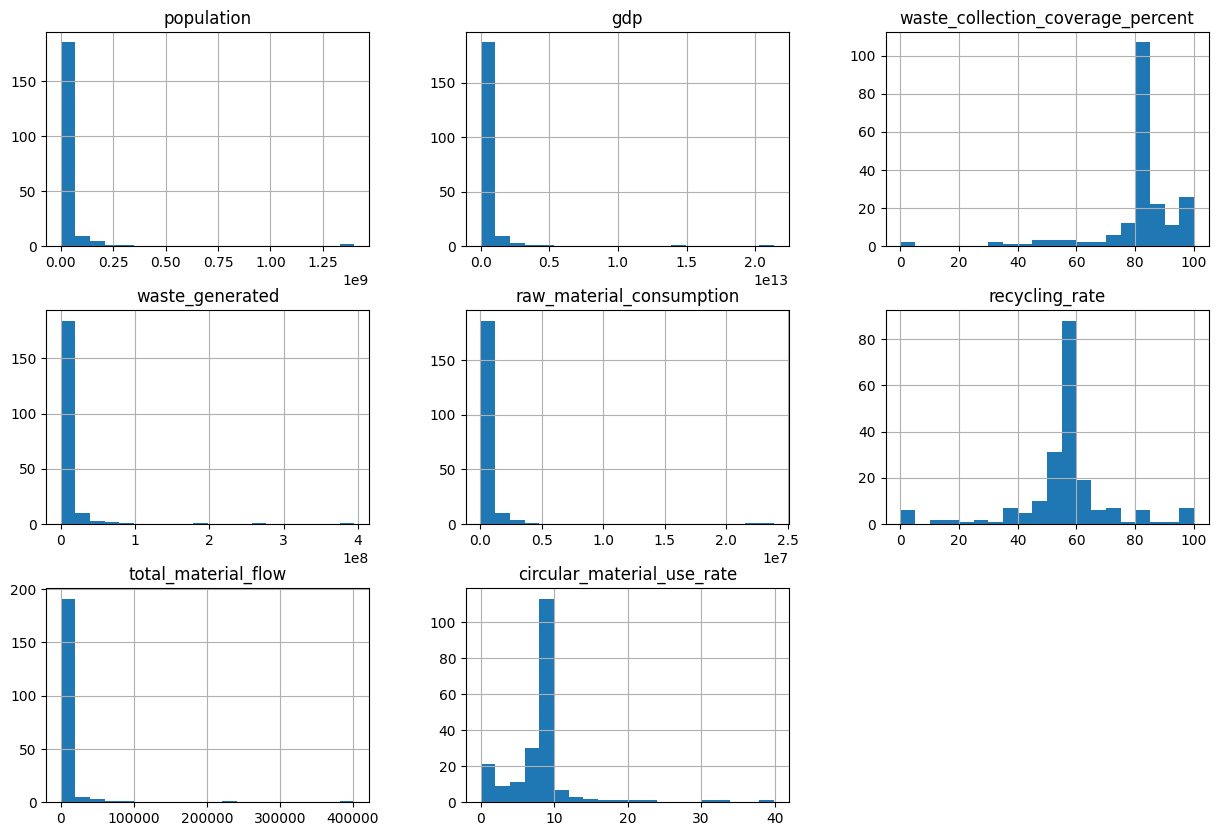

In [16]:
# Plot histogram of numerical columns
new_df.hist(bins=20, figsize=(15, 10))

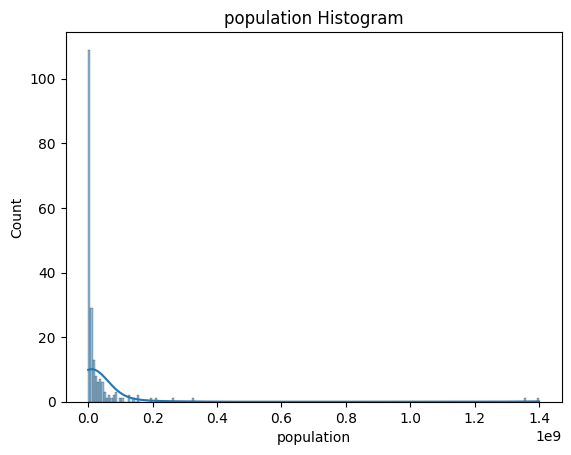

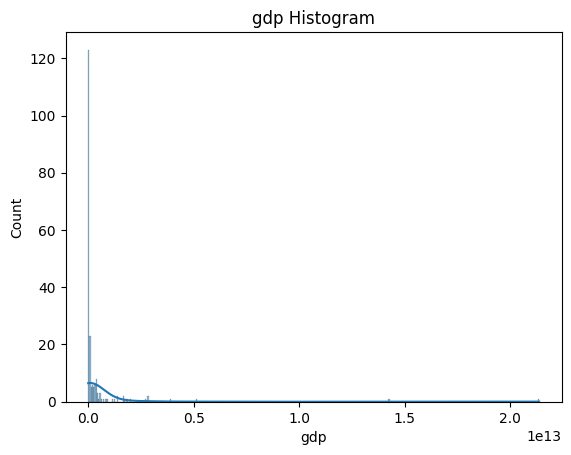

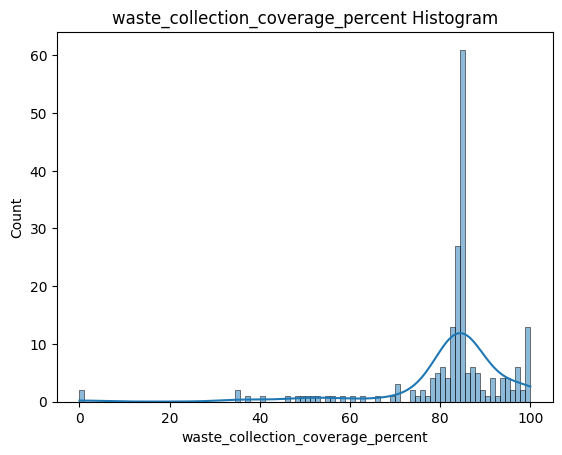

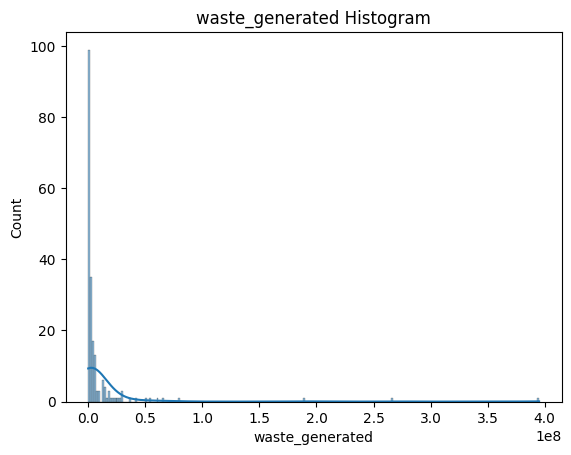

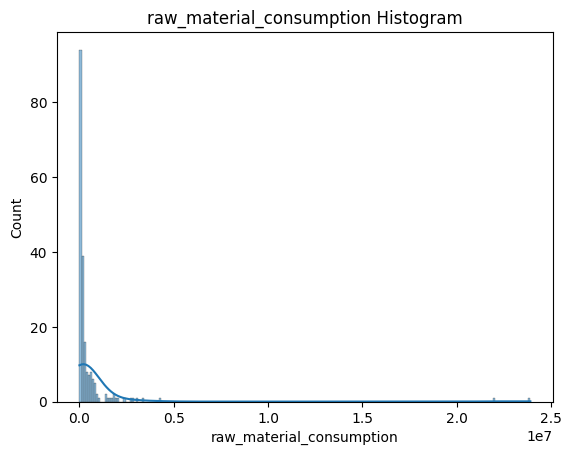

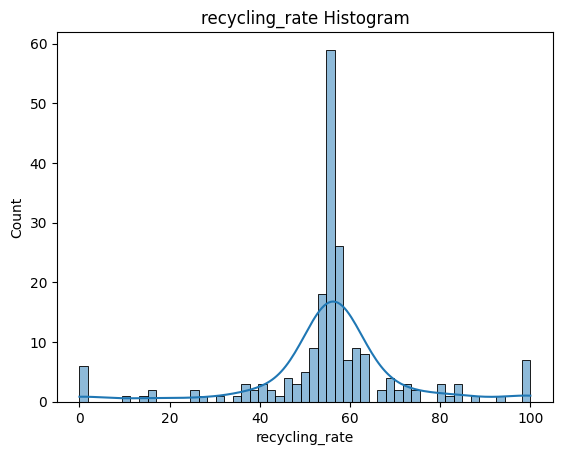

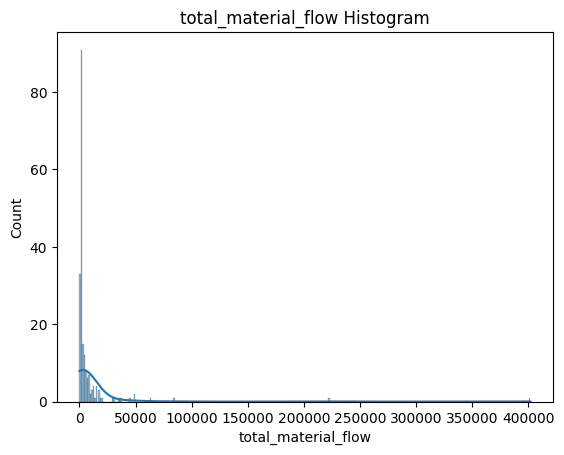

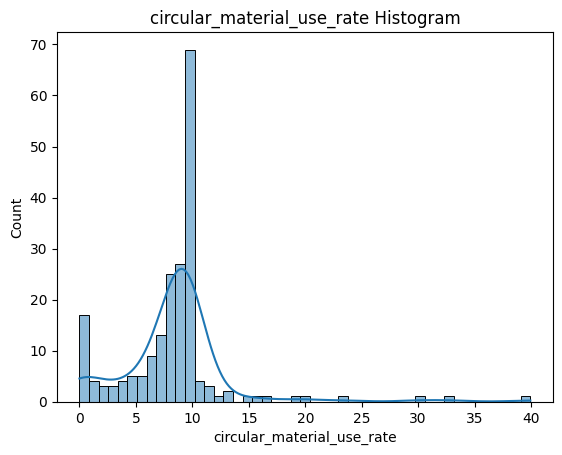

In [17]:
for c in new_df.columns[1:]:
    sns.histplot(data=new_df[c],  kde=True)
    plt.title(str(c + " Histogram"))
    plt.show()



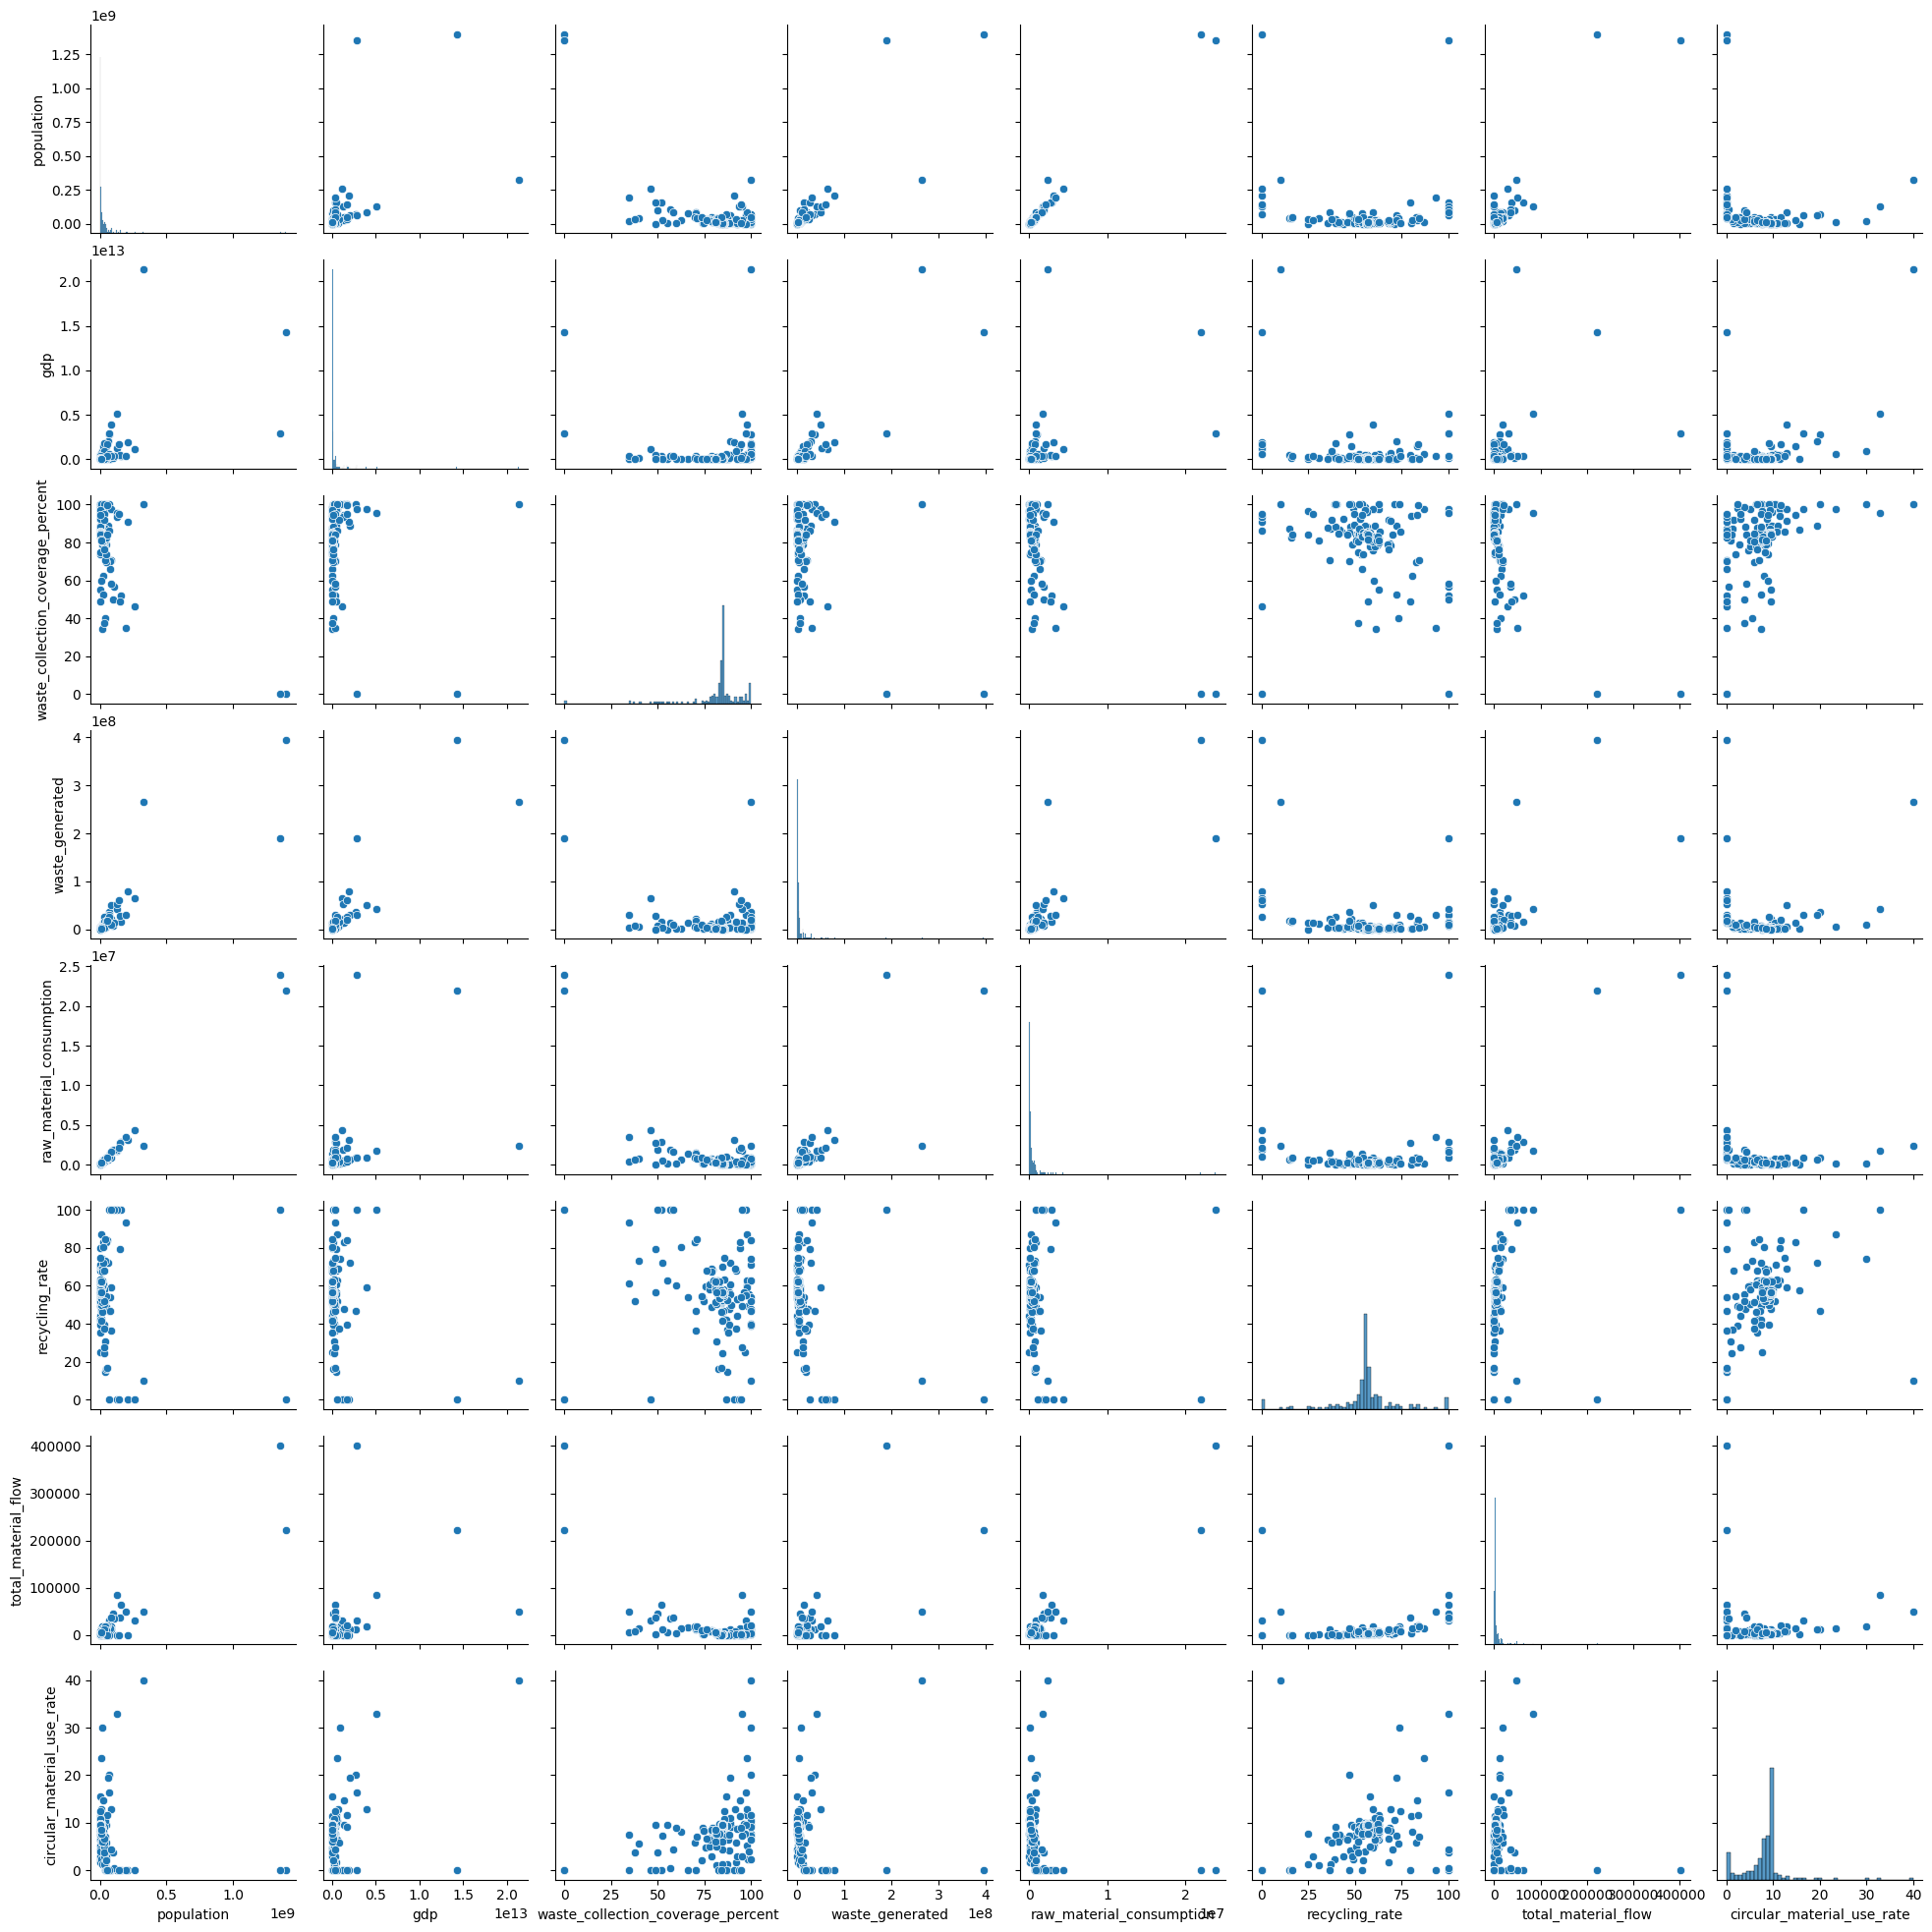

In [18]:
sns.pairplot(new_df)




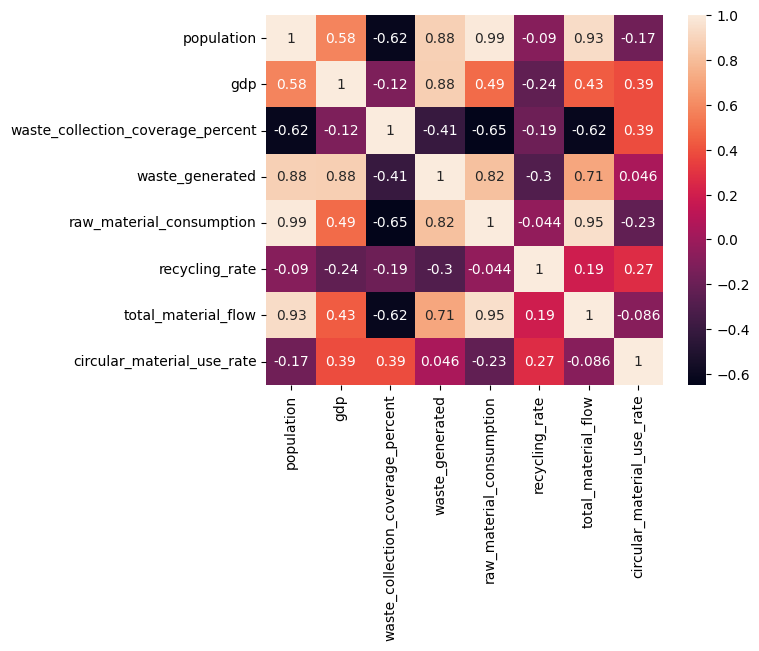

In [19]:
sns.heatmap(new_df.corr(), annot = True);

In [20]:
new_df.corr().style.background_gradient(cmap='coolwarm')


,population,gdp,waste_collection_coverage_percent,waste_generated,raw_material_consumption,recycling_rate,total_material_flow,circular_material_use_rate
population,1.000000,0.581051,-0.617548,0.879550,0.993246,-0.089530,0.929465,-0.174391
gdp,0.581051,1.000000,-0.119737,0.876541,0.485984,-0.239747,0.434270,0.385236
waste_collection_coverage_percent,-0.617548,-0.119737,1.000000,-0.405050,-0.647235,-0.186937,-0.616749,0.387473
waste_generated,0.879550,0.876541,-0.405050,1.000000,0.818930,-0.296825,0.705562,0.046389
raw_material_consumption,0.993246,0.485984,-0.647235,0.818930,1.000000,-0.043859,0.947022,-0.229513
recycling_rate,-0.089530,-0.239747,-0.186937,-0.296825,-0.043859,1.000000,0.190667,0.271876
total_material_flow,0.929465,0.434270,-0.616749,0.705562,0.947022,0.190667,1.000000,-0.085814
circular_material_use_rate,-0.174391,0.385236,0.387473,0.046389,-0.229513,0.271876,-0.085814,1.000000


# causal

In [21]:
causal_graph = """digraph {

population->waste_collection_coverage_percent;
population->waste_generated;
population->raw_material_consumption;
gdp->waste_collection_coverage_percent;
gdp->waste_generated;
gdp->recycling_rate;
gdp->total_material_flow;
gdp->raw_material_consumption;
waste_generated->waste_collection_coverage_percent;
waste_generated->recycling_rate;
waste_generated->circular_material_use_rate;
waste_generated->total_material_flow;
waste_collection_coverage_percent->recycling_rate;
waste_collection_coverage_percent->circular_material_use_rate;
waste_collection_coverage_percent->total_material_flow;
raw_material_consumption->waste_generated;
raw_material_consumption->total_material_flow;
raw_material_consumption->circular_material_use_rate
recycling_rate->total_material_flow;
recycling_rate->circular_material_use_rate;
total_material_flow->circular_material_use_rate;


}"""

In [22]:
def check_causality(treatment, outcome, df):
    causal_graph = """digraph {

    population->waste_collection_coverage_percent;
    population->waste_generated;
    population->raw_material_consumption;
    gdp->waste_collection_coverage_percent;
    gdp->waste_generated;
    gdp->recycling_rate;
    gdp->total_material_flow;
    gdp->raw_material_consumption;
    waste_generated->waste_collection_coverage_percent;
    waste_generated->recycling_rate;
    waste_generated->circular_material_use_rate;
    waste_generated->total_material_flow;
    waste_collection_coverage_percent->recycling_rate;
    waste_collection_coverage_percent->circular_material_use_rate;
    waste_collection_coverage_percent->total_material_flow;
    raw_material_consumption->waste_generated;
    raw_material_consumption->total_material_flow;
    raw_material_consumption->circular_material_use_rate
    recycling_rate->total_material_flow;
    recycling_rate->circular_material_use_rate;
    total_material_flow->circular_material_use_rate;


    }"""
    # print("################################################")
    # print("treatment = ", treatment)

    

    model = dowhy.CausalModel(data=df,
                              graph=causal_graph.replace("\n", " "),
                              treatment=treatment,
                              outcome=outcome)
    
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    #print(identified_estimand)

    causal_estimate_reg = model.estimate_effect(identified_estimand,
                                                method_name="backdoor.linear_regression",
                                                test_significance=True)
    
    #print(causal_estimate_reg)
    #print("Causal Estimate is " + str(causal_estimate_reg.value))

    # Double Machine Learning
    DML_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.econml.dml.DML",
                                        method_params={"init_params":{
                                            'model_y':LinearRegression(),
                                            'model_t':LinearRegression(),
                                            'model_final':LinearRegression()
                                                                    },
                                                    "fit_params":{}
                                                })
    #print(DML_estimate.value)
    # ATE = 0.2977
    
    

    refutation = model.refute_estimate(identified_estimand, causal_estimate_reg, method_name='placebo_treatment_refuter',
                                       placebo_type='permute', num_simulations=20)
    #print(refutation)

    refute_results = model.refute_estimate(identified_estimand, causal_estimate_reg, method_name="random_common_cause")
    #print(refute_results)
    return causal_estimate_reg.value

    
    


In [23]:
treatments = ["gdp","population","raw_material_consumption","recycling_rate","total_material_flow","waste_collection_coverage_percent","waste_generated"]

treatment_list = []
causal_estimate_list = []
for e in treatments:
    
    treatment_list.append(e)
    causal_estimate_list.append(check_causality(e, "circular_material_use_rate", new_df))



causal_estimate_df = pd.DataFrame({"treatment" : treatment_list, "causal_estimate" : causal_estimate_list})
causal_estimate_df

,treatment,causal_estimate
0,gdp,3.456245e-12
1,population,6.643044e-09
2,raw_material_consumption,2.411853e-05
3,recycling_rate,1.124625e-01
4,total_material_flow,2.008767e-04
5,waste_collection_coverage_percent,7.737082e-02
6,waste_generated,-6.161503e-07


## Treatement - recycling rate

In [24]:
model = dowhy.CausalModel(data=new_df,
                          graph=causal_graph.replace("\n", " "),
                          treatment="recycling_rate",
                          outcome="circular_material_use_rate")

In [25]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
────────────────(E[circular_material_use_rate|waste_generated,gdp,waste_collec
d[recyclingᵣₐₜₑ]                                                              

                       
tion_coverage_percent])
                       
Estimand assumption 1, Unconfoundedness: If U→{recycling_rate} and U→circular_material_use_rate then P(circular_material_use_rate|recycling_rate,waste_generated,gdp,waste_collection_coverage_percent,U) = P(circular_material_use_rate|recycling_rate,waste_generated,gdp,waste_collection_coverage_percent)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [26]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
────────────────(E[circular_material_use_rate|waste_generated,gdp,waste_collec
d[recyclingᵣₐₜₑ]                                                              

                       
tion_coverage_percent])
                       
Estimand assumption 1, Unconfoundedness: If U→{recycling_rate} and U→circular_material_use_rate then P(circular_material_use_rate|recycling_rate,waste_generated,gdp,waste_collection_coverage_percent,U) = P(circular_material_use_rate|recycling_rate,waste_generated,gdp,waste_collection_coverage_percent)

## Realized estimand
b: circular_material_use_rate~recycling_rate+waste_generated+gdp+waste_collection_coverage_percent
Target units: ate

## Estimate
Mean value: 0.1124625438552358

Causal Estimate is 0.1124625438552358


In [27]:
refutation = model.refute_estimate(identified_estimand, causal_estimate_reg, method_name='placebo_treatment_refuter',
                     placebo_type='permute', num_simulations=100)
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:0.1124625438552358
New effect:0.0006624147691990423
p value:0.98



In [28]:
refute_results = model.refute_estimate(identified_estimand, causal_estimate_reg, method_name="random_common_cause")
print(refute_results)

Refute: Add a random common cause
Estimated effect:0.1124625438552358
New effect:0.1125083704163102
p value:0.98



## Treatment - Waste collection coverage

In [29]:
model = dowhy.CausalModel(data=new_df,
                          graph=causal_graph.replace("\n", " "),
                          treatment="waste_collection_coverage_percent",
                          outcome="circular_material_use_rate")

In [30]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                 d                                                            
────────────────────────────────────(E[circular_material_use_rate|waste_genera
d[waste_collection_coverage_percent]                                          

                    
ted,gdp,population])
                    
Estimand assumption 1, Unconfoundedness: If U→{waste_collection_coverage_percent} and U→circular_material_use_rate then P(circular_material_use_rate|waste_collection_coverage_percent,waste_generated,gdp,population,U) = P(circular_material_use_rate|waste_collection_coverage_percent,waste_generated,gdp,population)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [31]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                 d                                                            
────────────────────────────────────(E[circular_material_use_rate|waste_genera
d[waste_collection_coverage_percent]                                          

                    
ted,gdp,population])
                    
Estimand assumption 1, Unconfoundedness: If U→{waste_collection_coverage_percent} and U→circular_material_use_rate then P(circular_material_use_rate|waste_collection_coverage_percent,waste_generated,gdp,population,U) = P(circular_material_use_rate|waste_collection_coverage_percent,waste_generated,gdp,population)

## Realized estimand
b: circular_material_use_rate~waste_collection_coverage_percent+waste_generated+gdp+population
Target units: ate

## Estimate
Mean value: 0.0773708235990398

Causal Estimate is 0.0773708235990398


In [32]:
refutation = model.refute_estimate(identified_estimand, causal_estimate_reg, method_name='placebo_treatment_refuter',
                     placebo_type='permute', num_simulations=100)
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:0.0773708235990398
New effect:-0.0030373840695375074
p value:0.8600000000000001



In [33]:
refute_results = model.refute_estimate(identified_estimand, causal_estimate_reg, method_name="random_common_cause")
print(refute_results)

Refute: Add a random common cause
Estimated effect:0.0773708235990398
New effect:0.07741121200702458
p value:0.98



# DML

In [34]:
model = dowhy.CausalModel(data=new_df,
                          graph=causal_graph.replace("\n", " "),
                          treatment="recycling_rate",
                          outcome="circular_material_use_rate")

In [35]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
────────────────(E[circular_material_use_rate|waste_generated,gdp,waste_collec
d[recyclingᵣₐₜₑ]                                                              

                       
tion_coverage_percent])
                       
Estimand assumption 1, Unconfoundedness: If U→{recycling_rate} and U→circular_material_use_rate then P(circular_material_use_rate|recycling_rate,waste_generated,gdp,waste_collection_coverage_percent,U) = P(circular_material_use_rate|recycling_rate,waste_generated,gdp,waste_collection_coverage_percent)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [36]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=2, include_bias=False),
                                                              'random_state': 100},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
────────────────(E[circular_material_use_rate|waste_generated,gdp,waste_collec
d[recyclingᵣₐₜₑ]                                                              

                       
tion_coverage_percent])
                       
Estimand assumption 1, Unconfoundedness: If U→{recycling_rate} and U→circular_material_use_rate then P(circular_material_use_rate|recycling_rate,waste_generated,gdp,waste_collection_coverage_percent,U) = P(circular_material_use_rate|recycling_rate,waste_generated,gdp,waste_collection_coverage_percent)

## Realized estimand
b: circular_material_use_rate~recycling_rate+waste_generated+gdp+waste_collection_coverage_percent | 
Target units: ate

## Estimate
Mean value: 0.026094602137483866
Effect estimates: [[0.0260946]]



In [37]:
refutation = model.refute_estimate(identified_estimand, dml_estimate, method_name='placebo_treatment_refuter',
                     placebo_type='permute', num_simulations=50)
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:0.026094602137483866
New effect:-0.00047256988744551567
p value:0.4774212352847431



In [38]:
refute_results = model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(refute_results)

Refute: Add a random common cause
Estimated effect:0.026094602137483866
New effect:0.02213702330718632
p value:0.9199999999999999



# lin reg coefficients

In [39]:
reg = LinearRegression().fit(new_df[new_df.columns.difference(["circular_material_use_rate","country"])], new_df["circular_material_use_rate"])

cdf = pd.DataFrame(reg.coef_, new_df[new_df.columns.difference(["circular_material_use_rate","country"])].columns, columns=['Coefficients'])
cdf

,Coefficients
gdp,1.675629e-12
population,2.970178e-07
raw_material_consumption,-1.679705e-05
recycling_rate,7.937339e-02
total_material_flow,8.449540e-05
waste_collection_coverage_percent,1.005376e-01
waste_generated,-2.283524e-07
